In [1]:
import pandas as pd
import anndata as ad
import screenpro as scp

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc_context

In [3]:
from matplotlib import font_manager as fm

from matplotlib import rcParams, rc_context

font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.family'] = ['Arial']

In [4]:
wd = '/data_gilbert/home/aarab/AML/Decitabine-treatment/DAC'

In [5]:
TFs_list = pd.read_csv('../annotations/TF_names_v_1.01.txt',header=None)[0].to_list()

In [6]:
import pandas as pd
# from plotnine import *

In [7]:
pagerdir='/data_gilbert/home/aarab/tools/pager'

In [9]:
# import blitzgsea as blitz

In [11]:
# msigdb_c5_go_gmt = blitz.enrichr.read_gmt(
#     f'{pagerdir}/annotations/human/msigdb_v7.4_c5.go/c5.go.v7.4.symbols.gmt'
# )

In [12]:
def get_replicate_score(screen,x_label, y_label, growth_rate=1):
    adata_ctrl = screen.adata[:,screen.adata.var.targetType.eq('negCtrl')].copy()

    results = {}
    
    for replicate in screen.adata.obs.replicate.unique():

        res = scp.ps.getPhenotypeScore(
            x = screen.adata[screen.adata.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y = screen.adata[screen.adata.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            x_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            growth_rate=growth_rate,
            math = screen.math,
            ave = 'row'
        )
        
        results.update({f'replicate_{replicate}':res})
    
    
    out = pd.DataFrame(
        results,
        index = screen.adata.var.index
    )
    return out

In [13]:
def plot_scatter_with_annotations(ax, phe, gamma, rho, target_name,exp='',selected_size=30, default_size=3):
    # Scatter plot for targeting data
    targeting_data = phe[phe['targetType'] == 'targeting']
    ax.scatter(targeting_data[gamma], targeting_data[rho],
               s=default_size, linewidth=0.3, edgecolors='black', facecolors='#3182bd', label='Targeting')

    # Scatter plot for non-targeting data
    non_targeting_data = phe[phe['targetType'] == 'negCtrl']
    ax.scatter(non_targeting_data[gamma], non_targeting_data[rho],
               s=default_size, linewidth=0, edgecolors='black', facecolors='gray', label='Non-Targeting')

    # Annotate the specified target name with increased size
    target_row = targeting_data[targeting_data['target'] == target_name]
    ax.scatter(target_row[gamma], target_row[rho],
               s=selected_size, linewidth=0.5, edgecolors='black', facecolors='#d73027', label=target_name)
    # # Annotate the specified target name
    # target_row = targeting_data[targeting_data['target'] == target_name]
    # ax.annotate(target_name, (target_row[gamma].iloc[0], target_row[rho].iloc[0]))

    # Set x-axis and y-axis labels
    ax.set_xlabel(f'{exp} gamma score')
    ax.set_ylabel(f'{exp} rho score')

    # # Add legend
    # ax.legend()

    ax.set_title(target_name)
    
    return ax

In [14]:
def plot_ggplot_pca(adata,fill,shape,legend_position= 'top',figure_size= (4.5, 5)):
    pca = pd.concat([
        pd.DataFrame(
            adata.obsm['X_pca'][:,[0,1]],
            index=adata.obs.index,
            columns=['PC-1','PC-2']
        ),
        adata.obs.drop('replicate',axis=1)
    ],axis=1)
    
    pca_p =  (ggplot(pca) 
     + geom_point(aes(
         x = 'PC-1',
         y = 'PC-2',
         fill=fill, 
         shape = shape
     ), color='black', size = 8)
     + theme_classic()
     + theme(
         panel_grid_major   = element_blank(), 
         panel_grid_minor   = element_blank(), 
         panel_background   = element_blank(), 

         legend_background  = element_blank(), 
         legend_position    = legend_position,
         legend_direction   = 'horizontal', # affected by the ncol=2
         # legend_text_legend = element_text(size=8),

         axis_line          = element_line(size=2),
         axis_text_x        = element_text(size=8),
         axis_text_y        = element_text(size=8),
         axis_title_x       = element_text(weight='bold', size=12),
         axis_title_y       = element_text(weight='bold', size=12),

         text               = element_text(font = 'arial'),

         figure_size        = figure_size
     )
    )

    return pca_p

### 

In [15]:
def find_low_counts(adata, filter_type = 'either',minimum_reads = 100, return_filtered=False):
    # Do you require greater than or equal to the minimum reads
    # for both experiments in a comparison or either experiment?
    # Default is either, other option is all
    count_bin = adata.X >= minimum_reads
    if filter_type == 'either':
        out = adata[:,count_bin.any(axis=0)].copy()
    elif filter_type == 'all':
        out = adata[:,count_bin.all(axis=0)].copy()
    
    # print the number of removed variables
    n_removed = adata.shape[1] - out.shape[1]
    print(
        f"{n_removed} variables with less than {minimum_reads} reads in {filter_type} replicates / experiment"
    )   
    
    if return_filtered:
        return out
    else:
        adata.var['low_count'] = ~adata.var.index.isin(out.var.index.to_list())

In [16]:
screens = {}

for exp in ['hl60_exp1','molm13_exp','skm1_exp']:
    name = exp.split('_')[0]
    cnt = pd.read_csv(f'{wd}/CRISPRi-screen/{exp}/mergedcountstable.txt',sep='\t', header=list(range(2)),index_col=list(range(1)))
    meta = cnt.columns.to_frame().reset_index(drop=True)
    samples = [f'{exp}_sample_{i+1}' for i in meta.index.to_list()]
    cnt.columns = samples
    meta.index = samples
    meta.columns = ['condition','replicate']
    meta.replicate = meta.replicate.str[-1].astype(int)
    
    oligo = cnt.index.to_frame()
    oligo.index.name = None
    oligo['target'] = oligo.sgId.str.split('_').str[0]
    del oligo['sgId']
    oligo['targetType'] = oligo.target.apply(lambda x: "negCtrl" if x == "non-targeting" else "targeting")
    oligo = oligo.sort_values('target').sort_values('targetType',ascending=False)
    oligo.targetType = pd.Categorical(oligo.targetType,categories=['targeting','negCtrl'])
    
    adata = ad.AnnData(X=cnt.loc[oligo.index,:].T.astype(float) + 1, var=oligo, obs=meta)
    scp.ps.seqDepthNormalization(adata)
    
    # adata = 
    find_low_counts(adata)
    
    phenotypetable = pd.read_csv(f'{wd}/CRISPRi-screen/{exp}/phenotypetable.txt',sep='\t',header=[0,1],index_col=0)
    genetable = pd.read_csv(f'{wd}/CRISPRi-screen/{exp}/genetable_collapsed.txt',sep='\t',header=[0,1,2],index_col=0)
    
    screens[name] = scp.ScreenPro(adata)
    screens[name].phenotypes.update({
        'phenotypetable':phenotypetable,
        'genetable':genetable
    })

3353 variables with less than 100 reads in either replicates / experiment
4783 variables with less than 100 reads in either replicates / experiment
3705 variables with less than 100 reads in either replicates / experiment


In [17]:
gamma_hl60 = screens['hl60'].phenotypes['phenotypetable']['gamma']#['ave_Rep1_Rep2']

In [18]:
gamma_hl60[gamma_hl60.index.str.contains('METTL14')]

,Rep1,Rep2,ave_Rep1_Rep2
sgId,,,
METTL14_+_119607013.23-P1P2,0.024501,0.027094,0.025797
METTL14_-_119606560.23-P1P2,-0.002057,-0.010708,-0.006382
METTL14_-_119606630.23-P1P2,0.010789,-0.036203,-0.012707
METTL14_-_119606721.23-P1P2,0.004758,0.042077,0.023417
METTL14_-_119606785.23-P1P2,0.009025,0.022760,0.015893


# 

In [19]:
rho_hl60 = screens['hl60'].phenotypes['phenotypetable']['rho']#['ave_Rep1_Rep2']

In [20]:
rho_hl60.loc[rho_hl60.index.str.contains('SPI1'),:]

,Rep1,Rep2,ave_Rep1_Rep2
sgId,,,
SPI1_+_47399936.23-P1P2,0.039316,-0.222827,-0.091755
SPI1_+_47400057.23-P1P2,NaN,NaN,NaN
SPI1_+_47400060.23-P1P2,-0.238292,-0.303112,-0.270702
SPI1_-_47399863.23-P1P2,NaN,NaN,NaN
SPI1_-_47400003.23-P1P2,NaN,NaN,NaN


In [21]:
import sys

sys.path.append('../scripts')

from util import *

In [22]:
from matplotlib_venn import venn3,venn3_circles, venn3_unweighted

In [23]:
def get_hits(rho,pval_thr):
    # filter
    rho = rho[~rho.index.str.contains('pseudo_')].copy()
    res,sen = find_top(rho,keep[0],0.1,keep[1],pval_thr)
    out = {'resistance':set(res.index.to_list()),
           'sensitizing':set(sen.index.to_list())
          }
    return out

In [24]:
def get_venn_genes_label(data,a_label,b_label,c_label,side_label,overlap_id):
    if overlap_id=='111':
        venn_genes_label = '\n'.join(list(
            data[a_label][side_label] & data[b_label][side_label] & data[c_label][side_label]
        ))
    elif overlap_id=='101':
        venn_genes_label = '\n'.join(list(
            (data[a_label][side_label] & data[c_label][side_label]) - data[b_label][side_label]
        ))
    elif overlap_id=='011':
        venn_genes_label = '\n'.join(list(
            (data[b_label][side_label] & data[c_label][side_label]) - data[a_label][side_label]
        ))
    elif overlap_id=='110':
        venn_genes_label = '\n'.join(list(
            (data[a_label][side_label] & data[b_label][side_label]) - data[c_label][side_label]
        ))
    elif overlap_id=='100':
        venn_genes_label = '\n'.join(list(
            (data[a_label][side_label] - data[b_label][side_label]) - data[c_label][side_label]
        ))
    elif overlap_id=='010':
        venn_genes_label = '\n'.join(list(
            (data[b_label][side_label] - data[a_label][side_label]) - data[c_label][side_label]
        ))
    elif overlap_id=='001':
        venn_genes_label = '\n'.join(list(
            (data[c_label][side_label] - data[a_label][side_label]) - data[b_label][side_label]
        ))
    
    return venn_genes_label

In [25]:
def venn_diagram_resistance(data,title_header='',size_scale=1,show_pval_thr=False,show_labels=None,save=None):
    plt.figure(figsize=(8*size_scale,8*size_scale))


    # Make venn diagram                                                                                                                                                             
    v = venn3_unweighted(
        [
            data['hl60']['resistance'],
            data['molm13']['resistance'],
            data['skm1']['resistance'],
        ],
        ('HL-60\nΔPhenotype (ρ)\nlog2FC > 0.1',
         'MOLM-13\nΔPhenotype (ρ)\nlog2FC > 0.1',
         'SKM-1\nΔPhenotype (ρ)\nlog2FC > 0.1')
        ,normalize_to=0.5
    )

    for x in ['100','010','001','110','101','011',
             '111'
             ]:
        v.get_patch_by_id(x).set_alpha(0.5)
        v.get_patch_by_id(x).set_color('lightgrey')
        v.get_label_by_id(x).set_fontsize(12)

    c = venn3_circles(
        (1,1,1,1,1,1,1), linestyle='dashed'
        ,normalize_to=0.5
    )
    for i,_ in enumerate(c):
        c[i].set_lw(1.0)
        c[i].set_ls('dotted')

    plt.title(f"{title_header}\nresistance", fontsize=20)
    if show_labels:
        for overlap_id in show_labels:
            v.get_patch_by_id(overlap_id).set_color('y')
            v.get_label_by_id(overlap_id).set_fontsize(15)

            venn_genes_label = get_venn_genes_label(data,'hl60','molm13','skm1','resistance',overlap_id)

            x_text, y_text = v.get_label_by_id(overlap_id).get_position()
            
            plt.annotate(
                venn_genes_label, 
                xy=(x_text,y_text) - np.array([0, 0.05]), 
                xytext=(x_text+200*size_scale,y_text+(-250*size_scale)),
                ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                fontsize=12,
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray')
            )

    if show_pval_thr:
        plt.figtext(
            0.5, 0.08, f"pvalue < {pval_thr}", ha="center", fontsize=10, 
            bbox={"facecolor":"lightgray", "alpha":0.1, "pad":5}
        )

    if save: plt.savefig(save)
    plt.show()


def venn_diagram_sensitizing(data,title_header='',size_scale=1,show_pval_thr=False, show_labels=None,save=None):
    plt.figure(figsize=(8*size_scale,8*size_scale))

    # Make venn diagram                                                                                                                                                             
    v = venn3_unweighted(
        [
            data['hl60']['sensitizing'],
            data['molm13']['sensitizing'],
            data['skm1']['sensitizing'],
        ],
        ('HL-60\nΔPhenotype (ρ)\nlog2FC < -0.1',
         'MOLM-13\nΔPhenotype (ρ)\nlog2FC < -0.1',
         'SKM-1\nΔPhenotype (ρ)\nlog2FC < -0.1')
        ,normalize_to=0.5
    )

    for x in ['100','010','001','110','101','011',
             '111'
             ]:
        v.get_patch_by_id(x).set_alpha(0.5)
        v.get_patch_by_id(x).set_color('lightgrey')
        v.get_label_by_id(x).set_fontsize(12)


    c = venn3_circles(
        (1,1,1,1,1,1,1), linestyle='dashed'
        ,normalize_to=0.5
    )
    for i,_ in enumerate(c):
        c[i].set_lw(1.0)
        c[i].set_ls('dotted')

    plt.title(f"{title_header}\nsensitizing", fontsize=20)
    if show_labels:
        for overlap_id in show_labels:
            v.get_patch_by_id(overlap_id).set_color('y')
            v.get_label_by_id(overlap_id).set_fontsize(15)

            venn_genes_label = get_venn_genes_label(data,'hl60','molm13','skm1','sensitizing',overlap_id)
            
            x_text, y_text = v.get_label_by_id(overlap_id).get_position()
            
            plt.annotate(
                venn_genes_label, 
                xy=(x_text,y_text) - np.array([0, 0.05]), 
                xytext=(x_text+200*size_scale,y_text+(-250*size_scale)),
                ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
                fontsize=12,
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray')
            )

    if show_pval_thr:
        plt.figtext(
            0.5, 0.08, f"pvalue < {pval_thr}", ha="center", fontsize=10, 
            bbox={"facecolor":"lightgray", "alpha":0.1, "pad":5}
        )

    if save: plt.savefig(save)
    plt.show()

In [26]:
# pval_thr = 0.025
pval_thr = 0.05

In [27]:
keep = ['average phenotype of strongest 3','Mann-Whitney p-value']

In [28]:
data = dict([
    (cell_line,get_hits(
        screens[cell_line].phenotypes['genetable']['rho']['ave_Rep1_Rep2'][keep], pval_thr) 
    )
    for cell_line in screens.keys()
])

up:  592
down: 705
up:  724
down: 528
up:  224
down: 944


In [29]:
[
    (cell_line,screens[cell_line].phenotypes['genetable']['rho']['ave_Rep1_Rep2'][keep].loc['METTL3'])
    for cell_line in screens.keys()
]

[('hl60',
  average phenotype of strongest 3    0.250638
  Mann-Whitney p-value                0.000581
  Name: METTL3, dtype: float64),
 ('molm13',
  average phenotype of strongest 3    0.484901
  Mann-Whitney p-value                0.001874
  Name: METTL3, dtype: float64),
 ('skm1',
  average phenotype of strongest 3    0.078701
  Mann-Whitney p-value                0.074443
  Name: METTL3, dtype: float64)]

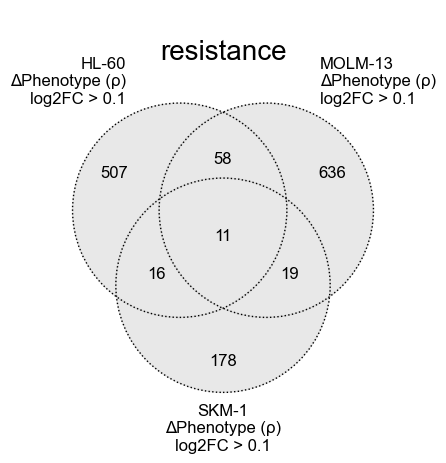

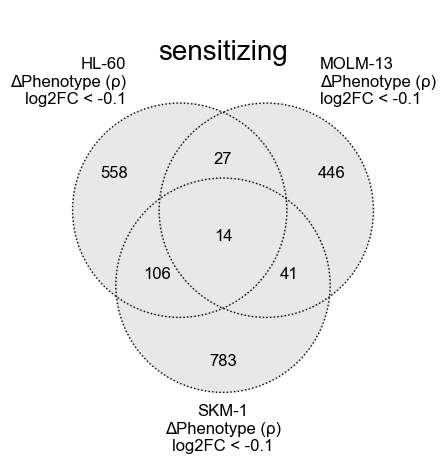

In [30]:
venn_diagram_resistance(
    data,
    size_scale=0.6,
    save='CRISPR-screens-resistance-gene-panel-venn.pdf')#,show_labels=['111'])
venn_diagram_sensitizing(
    data,
    size_scale=.6,
    save='CRISPR-screens-sensitizing-gene-panel-venn.pdf'
)#,show_labels=['111'])

### 

In [31]:
data_TFs = dict([
    (cell_line,get_hits(
        screens[cell_line].phenotypes['genetable']['rho']['ave_Rep1_Rep2'].loc[
            list(set(screens[cell_line].adata.var.target) & set(TFs_list)),keep], pval_thr) 
    )
    for cell_line in screens.keys()
])

up:  45
down: 38
up:  51
down: 39
up:  14
down: 53


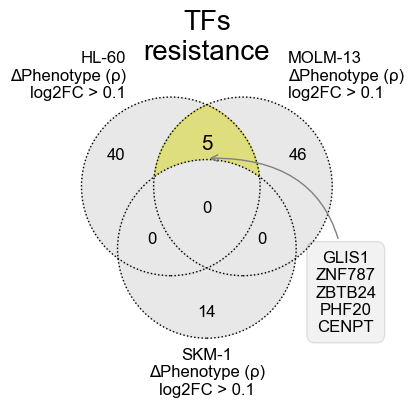

In [30]:
venn_diagram_resistance(data_TFs,'TFs',.5,show_labels=['110'])

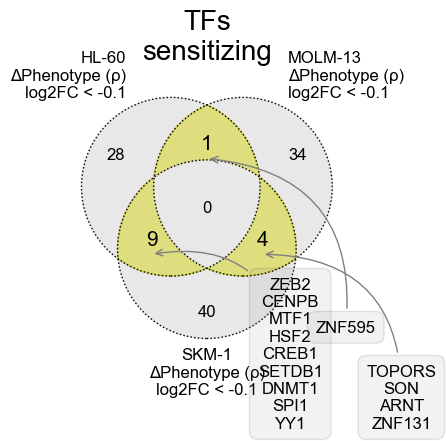

In [31]:
venn_diagram_sensitizing(data_TFs,'TFs',.5,show_labels=['011','101','110'])

In [988]:
set(data_TFs['hl60']['sensitizing']) & set(data_TFs['molm13']['sensitizing'])

{'ZNF595'}

In [989]:
set(data_TFs['hl60']['sensitizing']) & set(data_TFs['skm1']['sensitizing'])

{'CENPB', 'CREB1', 'DNMT1', 'HSF2', 'MTF1', 'SETDB1', 'SPI1', 'YY1', 'ZEB2'}

In [990]:
set(data_TFs['molm13']['sensitizing']) & set(data_TFs['skm1']['sensitizing'])

{'ARNT', 'SON', 'TOPORS', 'ZNF131'}

In [33]:


# ### 

# # msigdb_c5_go_gmt['GOBP_LEUKOCYTE_DIFFERENTIATION']

# # msigdb_c5_go_gmt['GOBP_MYELOID_LEUKOCYTE_DIFFERENTIATION']

# msigdb_c5_go_gmt['GOBP_CELL_DIFFERENTIATION_INVOLVED_IN_PHENOTYPIC_SWITCHING']

# data_GOBP_LEUKOCYTE_DIFFERENTIATION = dict([
#     (cell_line,get_hits(
#         screens[cell_line].phenotypes['genetable']['rho']['ave_Rep1_Rep2'].loc[
#             list(set(screens[cell_line].adata.var.target) & 
#                  set(msigdb_c5_go_gmt['GOBP_LEUKOCYTE_DIFFERENTIATION'])),keep], pval_thr) 
#     )
#     for cell_line in screens.keys()
# ])

# ___

# venn_diagram_resistance(
#     data_GOBP_LEUKOCYTE_DIFFERENTIATION,
#     'Leukocyte differentiation'
#     ,.5,show_labels=['110'])

# venn_diagram_sensitizing(
#     data_GOBP_LEUKOCYTE_DIFFERENTIATION,
#     'Leukocyte differentiation',.5,show_labels=['101','011'])





# # screens['hl60'].adata.var[screens['hl60'].adata.var.target.str.contains('METTL')]

# ### 

# data_GOBP_RNA_PROCESSING = dict([
#     (cell_line,get_hits(
#         screens[cell_line].phenotypes['genetable']['rho']['ave_Rep1_Rep2'].loc[
#             list(set(screens[cell_line].adata.var.target) & 
#                  set(msigdb_c5_go_gmt['GOBP_RNA_PROCESSING'])),keep], pval_thr) 
#     )
#     for cell_line in screens.keys()
# ])

# # venn_diagram_resistance(
# #     data_GOBP_RNA_PROCESSING,
# #     'RNA processing'
# #     ,.5,show_labels=['110','101','111'])

# venn_diagram_sensitizing(
#     data_GOBP_RNA_PROCESSING,
#     'RNA processing',.5,show_labels=['111'])

# ### 

# len(msigdb_c5_go_gmt['GOBP_METHYLATION'])

# data_GOBP_METYL = dict([
#     (cell_line,get_hits(
#         screens[cell_line].phenotypes['genetable']['rho']['ave_Rep1_Rep2'].loc[
#             list(set(screens[cell_line].adata.var.target) & 
#                  set(msigdb_c5_go_gmt['GOBP_METHYLATION'])),keep], pval_thr) 
#     )
#     for cell_line in screens.keys()
# ])

# venn_diagram_resistance(
#     data_GOBP_METYL,
#     'GO:0032259\nmethylation\n',.5,show_labels=['111','110','101'])

# venn_diagram_sensitizing(
#     data_GOBP_METYL,
#     'GO:0032259\nmethylation\n',.5,show_labels=['011','101'])









# # 

# gene_panel = [
#     'TP53',
#     'FTO','ALKBH5',
#     'DCK', 'SLC29A1', 'DCTD',
#     'BCL2', 'MCL1',
#     'DCPS', 'DCP2', 'DCP1A', 'SCAF8',
#     'METTL3', 'YTHDF2', 'YTHDC1', 'ZC3H13', 'VIRMA',#'KIAA1429', 
#     'CBLL1',
#     'PTEN', 'SQLE', 'INTS5', 'DHODH', 'MYBBP1A',
#     'INO80D', 'PMPCA', 'ZNF777', 'SLC7A6', 'RNF126', 'RBM14-RBM4',
# ]

# data_our_gene_panel = dict([
#     (cell_line,get_hits(
#         screens[cell_line].phenotypes['genetable']['rho']['ave_Rep1_Rep2'].loc[
#             list(set(screens[cell_line].adata.var.target) & 
#                  set(gene_panel)),keep], pval_thr) 
#     )
#     for cell_line in screens.keys()
# ])

# #### resistance

# venn_diagram_resistance(
#     data_our_gene_panel,
#     ' ',.8,show_labels=['100','101','110','010','111'],
#     save='CRISPR-screens-resistance-gene-panel-venn.pdf'
# )

# #### sensitizing

# venn_diagram_sensitizing(
#     data_our_gene_panel,
#     ' ',.8,
#     show_labels=['100','110','101','001'],
#     show_pval_thr=True,
#     save='CRISPR-screens-sensitizing-gene-panel-venn.pdf'
# )



# # set(data['hl60']['sensitizing']) & set(data['skm1']['sensitizing'])







# # adata_filt = adata[:,adata.to_df().sum(axis=0).gt(0)].copy()

# molm13_db = {
#     "untreated":10.04,
#     "treated":7.46,
# }





# # phe = pd.concat([
# #     # get_replicate_score(screens['hl60'],'untreated', 'treated',
# #     #                    molm13_db['untreated'] - molm13_db['treated'],
# #     #                    ).add_prefix('hl60_rho_'),
# #     scp.ps.runPhenoScoreForReplicate(screens['hl60'],'T0', 'untreated',
# #                        molm13_db['untreated']
# #                        ).add_prefix('hl60_gamma_'),
# #     scp.ps.runPhenoScoreForReplicate(screens['hl60'],'T0', 'treated',
# #                        molm13_db['treated'],
# #                        ).add_prefix('hl60_tau_'),
    
# #     # get_replicate_score(screens['molm13'],'DMSO', 'DAC',
# #     #                    molm13_db['untreated'] - molm13_db['treated'],
# #     #                    ).add_prefix('molm13_rho_'),
    
# #     scp.ps.runPhenoScoreForReplicate(screens['molm13'],'T0', 'DMSO',
# #                        molm13_db['untreated'],
# #                        ).add_prefix('molm13_gamma_'),
# #     scp.ps.runPhenoScoreForReplicate(screens['molm13'],'T0', 'DAC',
# #                        molm13_db['treated'],
# #                        ).add_prefix('molm13_tau_'),

# #     # get_replicate_score(screens['skm1'],'DMSO', 'DAC',
# #     #                     molm13_db['untreated'] - molm13_db['treated'],
# #     #                    ).add_prefix('skm1_rho_'),
    
# #     scp.ps.runPhenoScoreForReplicate(screens['skm1'],'T0', 'DMSO',
# #                         molm13_db['untreated']
# #                        ).add_prefix('skm1_gamma_'),
# #     scp.ps.runPhenoScoreForReplicate(screens['skm1'],'T0', 'DAC',
# #                         molm13_db['treated'],
# #                        ).add_prefix('skm1_tau_'),
# # ],axis=1).T

# # pdata = ad.AnnData(X=phe,var=oligo)

# # pdata.obs['cell_line'] = pdata.obs.index.str.split('_').str[0]
# # pdata.obs['score'] = pdata.obs.index.str.split('_').str[1]
# # pdata.obs['replicate'] = pdata.obs.index.str.split('_').str[-1]

# # pdata_filt = pd.concat(dict([(line,screens[line].adata.var['low_count']) for line in screens]),axis=1).sum(axis=1).gt(0)

# # pdata = pdata[:,~pdata_filt].copy()

# # pdata0 = pdata.copy()

# # pdata = pdata0[pdata0.obs.score.isin(['rho','gamma'])].copy()



# ### 

# sc.tl.pca(pdata)#, svd_solver='arpack')

# with rc_context({'figure.figsize': (3, 3)}):
#     sc.pl.pca_variance_ratio(pdata, n_pcs=8)
#     plt.tight_layout()
#     plt.show()

# with rc_context({'figure.figsize': (2, 2)}):
#     sc.pl.pca_scatter(pdata,color='score',size=300,alpha=0.7)
#     sc.pl.pca_scatter(pdata,color='cell_line',size=300,alpha=0.7)

# pca = plot_ggplot_pca(pdata,fill = 'cell_line',shape='score',legend_position=None,figure_size= (6, 3.5))

# pca#.save('pca.pdf')

# from screenpro.plotting import almost_black

# def draw_scatter(adata, x, y, title, ax):
#     bdata = adata[[x, y],:].copy()
    
#     print(bdata.shape)
    
#     bdata.obs.index = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
#     x_lab, y_lab = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    
#     sc.pp.log1p(bdata)
#     sc.pl.scatter(
#         bdata,
#         x_lab, y_lab,
#         legend_fontsize='xx-large',
#         palette=[almost_black,'#BFBFBF'],
#         color='targetType',
#         title=title,
#         size=5,
#         show=False,
#         ax = ax
#     )
#     ax.set_ylim(-2,1)
#     ax.set_xlim(-2,1)
#     ax.tick_params(axis='both', labelsize=10)
#     ax.get_legend().remove()
    
#     ax.grid(False)




# fig, axes = plt.subplots(ncols=4,
#                          figsize=(10,3), 
#                          gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
#                          # sharey=True
#                         )

# draw_scatter(pdata, 'hl60_gamma_replicate_1','hl60_gamma_replicate_2','hl60_gamma', axes[0])
# draw_scatter(pdata, 'hl60_tau_replicate_1','hl60_tau_replicate_2','hl60_tau', axes[1])

# draw_scatter(pdata, 'molm13_gamma_replicate_1','molm13_gamma_replicate_2','molm13_gamma', axes[2])
# draw_scatter(pdata, 'molm13_tau_replicate_1','molm13_tau_replicate_2','molm13_tau', axes[3])

# # fig.suptitle('PRDX1 parent screen',fontsize=15)

# # plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
# plt.show()

# fig, axes = plt.subplots(ncols=4,
#                          figsize=(10,3), 
#                          gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
#                          # sharey=True
#                         )
# draw_scatter(pdata0, 'hl60_gamma_replicate_1','hl60_gamma_replicate_2','hl60_gamma', axes[0])
# draw_scatter(pdata0, 'hl60_tau_replicate_1','hl60_tau_replicate_2','hl60_tau', axes[1])

# draw_scatter(pdata0, 'molm13_gamma_replicate_1','molm13_gamma_replicate_2','molm13_gamma', axes[2])
# draw_scatter(pdata0, 'molm13_tau_replicate_1','molm13_tau_replicate_2','molm13_tau', axes[3])

# # fig.suptitle('PRDX1 parent screen',fontsize=15)

# # plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
# plt.show()













# # 

# def plot_scatter_for_a_gene_on_three_cell_lines(gene_name):
#     # Create subplots and specify the size
#     fig, axes = plt.subplots(3, 2, figsize=(6, 9))

#     cell_line_names = {
#         'hl60':'HL-60',
#         'molm13':'MOLM13',
#         'skm1':'SKM1',
#     }

#     for i,rep_num in enumerate([1,2]):
#         for j,cell_line in enumerate(['hl60','molm13','skm1']):
#             plot_scatter_with_annotations(
#                 axes[j,i],
#                 pd.concat([pdata.var.T,pdata.to_df()],axis=0).T,
#                 gamma=f'{cell_line}_gamma_replicate_{rep_num}',
#                 rho=f'{cell_line}_rho_replicate_{rep_num}',
#                 target_name=gene_name,
#                 exp = f'{cell_line_names[cell_line]} CRISPRi (Rep {rep_num})'
#             )

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# def rank_plot(series, highlight_values=None, xlabel='Rank', ylabel='Values', title='Rank Plot',dot_size=3,highlight_color='red', highlight_size_factor=2):
#     """
#     Create a rank plot for a pandas Series.

#     Parameters:
#     - series: pd.Series
#         The input pandas Series for which the rank plot is to be created.
#     - xlabel: str, optional
#         The label for the x-axis.
#     - ylabel: str, optional
#         The label for the y-axis.
#     - title: str, optional
#         The title of the plot.

#     Returns:
#     - None
#     """
#     # Create a copy of the series and sort it
#     sorted_series = series.sort_values(ascending=True)

#     # Create a new DataFrame with the values and their corresponding ranks
#     rank_df = pd.DataFrame({'Rank': range(1, len(sorted_series) + 1), 'Values': sorted_series.values})

#     # Use a color that is suitable for publications
#     plot_color = '#3498db'  # A shade of blue

#     # Plot the ranks against their values with specified color
#     plt.figure(figsize=(6, 3))
#     plt.plot(rank_df['Rank'], rank_df['Values'], marker='o', linestyle='-', color=plot_color,markersize=dot_size)

#     # Add labels and title
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.title(title)

#     # Customize the grid lines for a clean look
#     # plt.grid(True, linestyle='--', alpha=0.7)
#     plt.grid(False)

#     # Show the plot
#     plt.show()

# d = pdata.to_df().T['molm13_rho_replicate_2'].T

# rank_plot(d,d.sort_values()[:10].index)













# plot_scatter_for_a_gene_on_three_cell_lines('DCK')

# plot_scatter_for_a_gene_on_three_cell_lines('SLC29A1')

# plot_scatter_for_a_gene_on_three_cell_lines('DHODH')

# # 

# Ca_library = pd.read_csv('../DAC/CRISPRa-screen/CRISPRa_v2_mouse_librarytable.txt',sep='\t',index_col=0)
# Ca_library.rename(columns={'gene':'target'},inplace=True)
# Ca_library['targetType'] = Ca_library.target.apply(lambda x: "negCtrl" if x == "negative_control" else "targeting")
# Ca_library = Ca_library.sort_values('target').sort_values('targetType',ascending=False)
# Ca_library.targetType = pd.Categorical(Ca_library.targetType,categories=['targeting','negCtrl'])

# Ca = pd.read_csv(
#     '../DAC/CRISPRa-screen/GSE240570_raw_counts.txt.gz',
#     sep='\t',header=[0,1],index_col=0
# )
# meta = Ca.columns.to_frame(name=['condition','replicate']).reset_index(drop=True)
# meta.replicate = meta.replicate.str[-1].astype(int)

# Ca_screen = scp.ScreenPro(
#     ad.AnnData(
#         Ca.T.reset_index(drop=True),
#         var=Ca_library.loc[Ca.index,:],
#         obs=meta
#     )
# )

# Ca_phe = pd.concat([
#     get_replicate_score(Ca_screen,x_label='DMSO',y_label='DAC').add_prefix('rho_'),
#     get_replicate_score(Ca_screen,x_label='T0',y_label='DMSO').add_prefix('gamma_'),
# ],axis=1)

# Ca_phe = pd.concat([Ca_phe, Ca_library.loc[Ca_phe.index,]],axis=1)

# # plot_scatter_with_annotations(
# #     Ca_phe,
# #     gamma='gamma_replicate_1',
# #     rho='rho_replicate_1',
# #     target_name='Dck',
# #     exp = 'CRISPRa'
# # )

# # plot_scatter_with_annotations(
# #     Ca_phe,
# #     gamma='gamma_replicate_1',
# #     rho='rho_replicate_1',
# #     target_name='Slc29a1',
# #     exp = 'CRISPRa'
# # )

# # d = Ca_phe['gamma_replicate_1'].T

# # rank_plot(d,d.sort_values()[:10].index)

# d = Ca_phe['rho_replicate_1'].T

# rank_plot(d,d.sort_values()[:10].index)

# # 

# # from upsetplot import from_contents,UpSet

# # import sys

# # sys.path.append('../scripts/')

# # from util import find_top

# # def read_rho_phenotype_table(screen_path):
# #     df = pd.read_csv(
# #             f'{screen_path}/genetable_collapsed.txt',
# #             sep='\t',
# #             header=list(range(3)), 
# #             index_col=list(range(1))
# #         )['rho']['ave_Rep1_Rep2'].reset_index()[
# #         ['gene','average phenotype of strongest 3','Mann-Whitney p-value']
# #     ]
# #     df.columns = ['target','rho score','pvalue']
# #     df = scp.utils.ann_score_df(df,ctrl_label='pseudo')
# #     return df.set_index('target')

# # pd.concat([
# #     read_rho_phenotype_table(f'{wd}/CRISPRi-screen/hl60_exp1/').add_prefix('hl60_'),
# #     read_rho_phenotype_table(f'{wd}/CRISPRi-screen/skm1_exp/').add_prefix('skm1_'),
# #     read_rho_phenotype_table(f'{wd}/CRISPRi-screen/molm13_exp/').add_prefix('molm13_'),
# # ],axis=1)

# Exp_up = set(Top['Exp']['up'].gene_name.to_list())# + u[1].gene_name.tolist())
# Rho_up = set(Top['Rho']['up'].index.tolist())
# Stbl_up = set(Top['Stbl']['up'].gene_name.tolist())
# TE_up = set(Top['TE']['up'].gene_name.tolist())
# Hyper_m6A = set(Top['Mtyl']['up'].gene_name.tolist())

# Exp_down = set(Top['Exp']['down'].gene_name.tolist())# + d[1].gene_name.tolist())
# Stbl_down = set(Top['Stbl']['down'].gene_name.tolist())
# Rho_down = set(Top['Rho']['down'].index.tolist())
# TE_down = set(Top['TE']['down'].gene_name.tolist())
# Hypo_m6A = set(Top['Mtyl']['down'].gene_name.tolist())

# 'MYBBP1A' in Rho_down 

# 'INTS5' in Exp_down

# upset_data = {
#     'Hyper_m6A':Hyper_m6A,
#     # 'Hypo_m6A':Hypo_m6A,

#     'Exp_up':Exp_up,
#     'Rho_up':Rho_up,
#     # 'Stbl_up':Stbl_up,
#     'TE_up':TE_up,

#     'Exp_down':Exp_down,
#     # 'Stbl_down':Stbl_down,
#     'Rho_down':Rho_down,
#     'TE_down':TE_down
# }

# with PdfPages('intersectional-genes/comparisons_upset_plot.pdf') as pdf:
#     # Hyper_m6A_upset_data
#     fig1 = plt.figure()
#     upset1 = us.UpSet(
#         us.from_contents(upset_data),
#         min_degree=3,
#         sort_by='cardinality',
#         # orientation='vertical',
#         show_counts=True,
#         # totals_plot_elements=
#         other_dots_color=0.2,
#         facecolor='lightgrey'
#     )
#     upset1.style_subsets(
#         present=["Rho_down","Hyper_m6A"], 
#         # absent='Hypo_m6A',
#         label="Hyper m6A & Rho down", 
#         facecolor='brown'
#         #, edgecolor='dimgrey',linewidth=0.5,linestyle='--'
#     )
    
#     upset1.style_subsets(
#         present=["Exp_down","Hyper_m6A"], 
#         # absent='Hypo_m6A',
#         label="Hyper m6A & Exp down", 
#         # facecolor='brown', 
#         edgecolor='darkgreen',linewidth=2#,linestyle='--'
#     )

#     upset1.plot(fig=fig1)
#     plt.title('Differential analysis intersections',fontsize=12)
#     pdf.savefig(bbox_inches='tight')

# 

In [34]:
%reload_ext watermark

In [35]:
%watermark

Last updated: 2024-03-13T16:46:52.055071-07:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.18.1

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [36]:
%watermark --iversions

screenpro : 0.2.6
anndata   : 0.10.5.post1
pandas    : 1.5.3
seaborn   : 0.13.2
numpy     : 1.26.4
sys       : 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
matplotlib: 3.6.3
scanpy    : 1.9.8



In [37]:
!date

Wed Mar 13 16:46:55 PDT 2024
